In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicyDemoAdaptiveAlpha, PolicySimulator, createEnv
from MdpSolverLibs import MdpKernel

In [9]:
configIdx = 4
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="test", type="data")

Environment Configuration
Number of Users:        8
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              200
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_bk
DB Parameter:           0.012
Alpha:                  0.01
Mode:                   fixed
Direction:              backward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [10]:
num_windows = 2000
N_episodes = 10
obvMode = "predicted" # "perfect" or "predicted"
if configIdx in [0,1,2,3]:
    with open(f'Results/MdpPolicy/mdpKernelParams_config{configIdx}.pkl', 'rb') as f:
        mdpKernelParams = pickle.load(f)
    mdpPolicyDeter = MdpKernel()
    mdpPolicyDeter.load_policy(mdpKernelParams, policyMode="deterministic", randomR=False)
    mdpPolicyStoch = MdpKernel()
    mdpPolicyStoch.load_policy(mdpKernelParams, policyMode="deterministic", randomR=True)
    adaptiveAlphaPolicy = PolicyDemoAdaptiveAlpha(envParams)

    policySimulator = PolicySimulator(env)
    policySimulator.setupModes(obvMode=obvMode, mode="test", type="data")
    # =========== MdpDeter ===========  
    policySimulator.loadPolicies([mdpPolicyDeter], [[0,1,2,3]])
    simResultMdpDeter = policySimulator.runSimulation(num_windows=num_windows, N_episodes=N_episodes)
    # =========== MdpStoch ===========  
    policySimulator.loadPolicies([mdpPolicyStoch], [[0,1,2,3]])
    simResultMdpStoch = policySimulator.runSimulation(num_windows=num_windows, N_episodes=N_episodes)
    # =========== AdaptiveAlpha ===========  
    policySimulator.loadPolicies([adaptiveAlphaPolicy], [[0,1,2,3]])
    simResultAdaptive = policySimulator.runSimulation(num_windows=num_windows, N_episodes=N_episodes)

    print(f"avg_reward_mdpDeter: {np.mean(simResultMdpDeter['rewardRecord'])}\n" + 
        f"avg_reward_mdpStoch: {np.mean(simResultMdpStoch['rewardRecord'])}\n" + 
        f"avg_reward_adaptive: {np.mean(simResultAdaptive['rewardRecord'])}")

    plt.plot(simResultAdaptive['rewardRecord'], label="adaptiveAlpha")
    plt.plot(simResultMdpDeter['rewardRecord'], label="mdpDeter")
    plt.plot(simResultMdpStoch['rewardRecord'], label="mdpStoch")
    plt.legend()
    plt.show()

Simulation Progress: 100%|██████████| 2000/2000 [00:07<00:00, 282.59it/s]


avg_reward_mdpDeter: 0.0037986975734721393
avg_reward_mdpStoch: 0.004456364640708042
avg_reward_adaptive: 0.014342087330347579


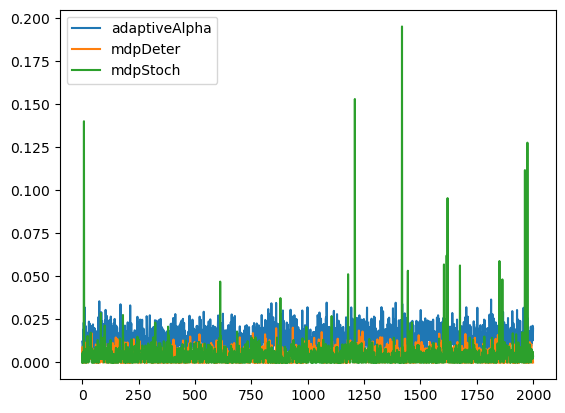

In [14]:
num_windows = 2000
N_episodes = 10
obvMode = "predicted" # "perfect" or "predicted"
if configIdx in [4,5,6,7]:
    with open(f'Results/MdpPolicy/mdpKernelParams_config{0}.pkl', 'rb') as f:
        mdpKernelParams = pickle.load(f)
    mdpPolicyDeter = MdpKernel()
    mdpPolicyDeter.load_policy(mdpKernelParams, policyMode="deterministic", randomR=False)
    mdpPolicyStoch = MdpKernel()
    mdpPolicyStoch.load_policy(mdpKernelParams, policyMode="deterministic", randomR=True)
    adaptiveAlphaPolicy = PolicyDemoAdaptiveAlpha(envParams)

    policySimulator = PolicySimulator(env)
    policySimulator.setupModes(obvMode=obvMode, mode="test", type="data")
    # =========== MdpDeter ===========  
    policySimulator.loadPolicies([mdpPolicyDeter, mdpPolicyDeter], [[0,1,2,3], [4,5,6,7]])
    simResultMdpDeter = policySimulator.runSimulation(num_windows=num_windows, N_episodes=N_episodes)
    # =========== MdpStoch ===========  
    policySimulator.loadPolicies([mdpPolicyStoch, mdpPolicyStoch], [[0,1,2,3], [4,5,6,7]])
    simResultMdpStoch = policySimulator.runSimulation(num_windows=num_windows, N_episodes=N_episodes)
    # =========== AdaptiveAlpha ===========  
    policySimulator.loadPolicies([adaptiveAlphaPolicy], [[0,1,2,3, 4,5,6,7]])
    simResultAdaptive = policySimulator.runSimulation(num_windows=num_windows, N_episodes=N_episodes)

    print(f"avg_reward_mdpDeter: {np.mean(simResultMdpDeter['rewardRecord'])}\n" + 
        f"avg_reward_mdpStoch: {np.mean(simResultMdpStoch['rewardRecord'])}\n" + 
        f"avg_reward_adaptive: {np.mean(simResultAdaptive['rewardRecord'])}")

    plt.plot(simResultAdaptive['rewardRecord'], label="adaptiveAlpha")
    plt.plot(simResultMdpDeter['rewardRecord'], label="mdpDeter")
    plt.plot(simResultMdpStoch['rewardRecord'], label="mdpStoch")
    plt.legend()
    plt.show()

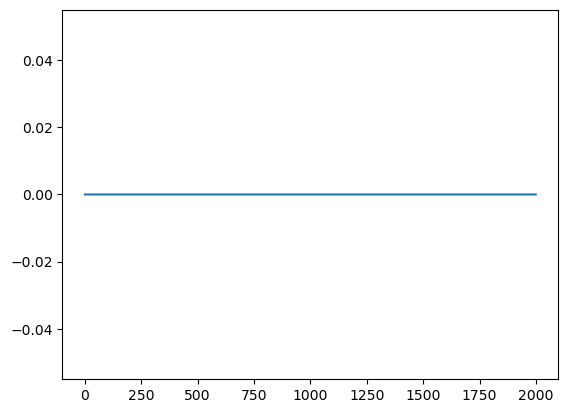

In [12]:
def _preprocess_reward(actions, bandwidth):
    # actions: list of tuples (w, r, M, alpha)
    # Each w, r is a vector (per user), alpha is scalar
    w_list, r_list, _, alpha_list = zip(*actions)
    w_arr = np.stack(w_list)  # shape: (N, N_user)
    r_arr = np.stack(r_list)  # shape: (N, N_user)
    alpha_arr = np.array(alpha_list)  # shape: (N,)
    # Compute cost per sample
    cost = np.sum(w_arr * r_arr, axis=1)  # shape: (N,)
    excess = cost - alpha_arr * bandwidth
    penalty = excess > 0
    return penalty

actions = simResultMdpDeter['actionsRecord']
bandwidth = envParams['B']

plt.plot(_preprocess_reward(actions, bandwidth))
plt.show()